# Planets Image Classifier

This notebook contains the code for making an image classifier for the planets in the solar system. We will see how to easily create an image dataset through Google Images.

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. Then, using the instructions on this [website](http://bskog.com/ai/2018/10/30/creating-dataset-google-image-search-results/), I downloaded images for all 8 planets in our solar system.

### Create directory and upload urls file into your server

In [3]:
from fastai import *
from fastai.vision import *

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels. Each planet is a category. And each category needs to be run separately with the lines of code below where path, dest, mkdir and download_images are.

In [4]:
folder = 'mercury'
file = 'mercury.txt'

In [25]:
folder = 'venus'
file = 'venus.txt'

In [30]:
folder = 'earth'
file = 'earth.txt'

In [34]:
folder = 'mars'
file = 'mars.txt'

In [39]:
folder = 'jupiter'
file = 'jupiter.txt'

In [42]:
folder = 'saturn'
file = 'saturn.txt'

In [3]:
folder = 'uranus'
file = 'uranus.txt'

In [4]:
folder = 'neptune'
file = 'neptune.txt'

You will need to run this line once per each category.

In [5]:
path = Path('data/planets')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [6]:
folder

'mercury'

## Download images

Now you will need to download you images from their respective urls.

You just have to specify the urls filename and the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [ ]:
download_images(dest/file, dest, max_pics=500)

In [ ]:
# If you have problems download, try with `max_workers=0` to see exceptions:
download_images(path/file, dest, max_pics=20, max_workers=0)

Then we can remove any images that can't be opened:

In [6]:
classes = ['mercury','venus','earth','mars','jupiter','saturn','uranus','neptune']

In [20]:
'''for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)'''

'for c in classes:\n    print(c)\n    verify_images(path/c, delete=True, max_workers=8)'

## View data

In [12]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [8]:
data.classes

['earth', 'jupiter', 'mars', 'mercury', 'neptune', 'saturn', 'uranus', 'venus']

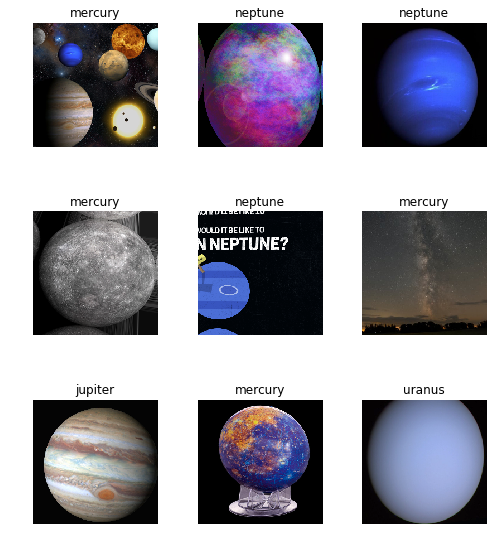

In [23]:
data.show_batch(rows=3, figsize=(7,8))

In [58]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['earth',
  'jupiter',
  'mars',
  'mercury',
  'neptune',
  'saturn',
  'uranus',
  'venus'],
 8,
 2163,
 571)

## Train model

In [24]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [25]:
learn.fit_one_cycle(4)

Total time: 02:49
epoch  train_loss  valid_loss  accuracy
1      1.933245    1.321444    0.584337  (00:42)
2      1.596495    1.231834    0.590361  (00:41)
3      1.372073    1.218022    0.622490  (00:43)
4      1.224081    1.219329    0.614458  (00:41)



In [26]:
learn.save('planets-stage-1')

In [27]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


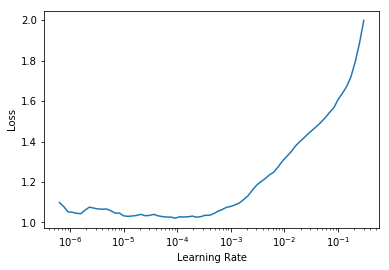

In [29]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, max_lr=slice(3e-6,3e-4))

Total time: 03:48
epoch  train_loss  valid_loss  error_rate
1      2.495460    1.901617    0.690763    (00:42)
2      2.174677    1.517539    0.506024    (00:45)
3      1.946532    1.395093    0.465863    (00:47)
4      1.787983    1.360034    0.449799    (00:46)
5      1.687782    1.350635    0.445783    (00:46)



In [31]:
learn.save('planets-stage-2')

## Interpretation

In [32]:
learn.load('planets-stage-2')

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

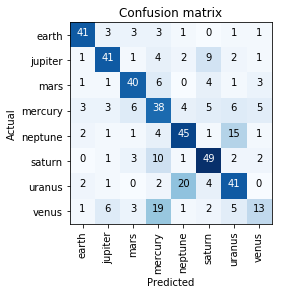

In [34]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `FileDeleter` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. Here's a handy function that pulls out all our top_losses:

In [20]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.train_ds.x[idxs]

Now we can pass in these paths to our widget.

In [21]:
fd = FileDeleter(file_paths=top_loss_paths)

'No images to show :)'

Flag photos for deletion by clicking 'Delete'. Then click 'Confirm' to delete flagged photos and keep the rest in that row. The `File_Deleter` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses`.

## Putting your model in production

In [35]:
data.classes

['earth', 'jupiter', 'mars', 'mercury', 'neptune', 'saturn', 'uranus', 'venus']

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
# fastai.defaults.device = torch.device('cpu')

In [11]:
path = Path('data/planets')
img = open_image(path/'earth'/'00000023.jpg')

In [6]:
classes = ['earth', 'jupiter', 'mars', 'mercury', 'neptune', 'saturn', 'uranus', 'venus']
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load('planets-stage-2')

In [9]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'earth'

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [13]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [14]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:50
epoch  train_loss  valid_loss  error_rate 
1      25.278343   2422.211914  0.861446    (00:50)



### Learning rate (LR) too low

In [15]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [16]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 03:45
epoch  train_loss  valid_loss  error_rate
1      2.679936    2.277150    0.877510    (00:43)
2      2.642024    2.253451    0.861446    (00:43)
3      2.653915    2.216545    0.849398    (00:45)
4      2.625527    2.207940    0.839357    (00:46)
5      2.632029    2.205151    0.851406    (00:45)



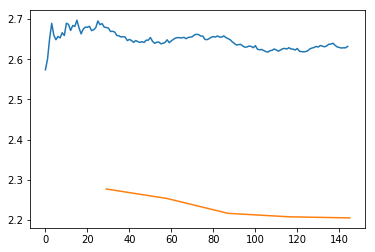

In [17]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [21]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [22]:
learn.fit_one_cycle(1)

Total time: 00:45
epoch  train_loss  valid_loss  error_rate
1      1.817824    1.375534    0.437751    (00:45)



### Too many epochs

In [23]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [24]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 111229086.98it/s]


In [25]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 01:58
epoch  train_loss  valid_loss  error_rate
1      2.341251    2.158661    0.852637    (00:42)
2      2.069199    1.906413    0.691149    (00:38)
3      1.802211    1.842675    0.666196    (00:37)

